In [13]:
import os
import sys
from sys import platform
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_total_iterations

In [14]:
_config = get_global_config()
HP_CONFIG_PATH = os.path.join(BASE_PATH, _config.get('HP_CONFIG_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH'))
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [15]:
experiments = []

for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))

experiments = sorted(experiments)

results = {
	'emissions': [],
	'duration': [],
	'cpu_power': [], 'gpu_power': [], 'ram_power': []
}
metrics = {
	'recall@10': [],
	'ndcg@10': [],
	'averagepopularity@10': [],
	'giniindex@10': []
}

In [16]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"ID":<5}{"DATASET":<18}{"MODEL":<8}{"RUNs":>8}{"DURATION(h)":>15}{"EMISSIONS(g)":>15}\n')
print(''.join(['> ' for i in range(40)]))
for i, v in enumerate(experiments):
	emissions_df = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
	metrics_df = pd.read_csv(os.path.join(RESULTS_PATH, v, METRICS_FILE))
	e = emissions_df[
		['project_name', 'duration', 'emissions', 'cpu_power', 'gpu_power', 'ram_power']
	].groupby(['project_name']).sum()
	m = metrics_df[
		['project_name', 'recall@10', 'ndcg@10', 'averagepopularity@10', 'giniindex@10']
	].groupby(['project_name']).max()
	if len(e) > 1 or len(m) > 1:
		raise Exception()
	else:
		for k in results.keys():
			if k == 'emissions':
				results[k].append(e.iloc[0][k]*1000)
			else:
				results[k].append(e.iloc[0][k])
		for k in metrics.keys():
			metrics[k].append(m.iloc[0][k])
		print(f'\n{i+1:<5}{v.split("/")[0]:<18}{v.split("/")[1]:<8}{get_total_iterations(HP_CONFIG_PATH + v.split("/")[1] + ".hyper"):>8}{str(datetime.timedelta(seconds=int(e.iloc[0]["duration"]))):>15}{e.iloc[0]["emissions"]*1000:>15.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL       RUNs    DURATION(h)   EMISSIONS(g)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    movielens         BPR           27        0:10:41           0.10

2    movielens         CFKG         162        2:00:19           3.31

3    movielens         CKE          243       10:04:54          18.89

4    movielens         DGCF         243       19:12:34          40.89

5    movielens         DMF           81        0:45:40           1.18

6    movielens         FISM          54        5:27:31           9.36

7    movielens         ItemKNN      216        0:51:20           0.02

8    movielens         KGNNLS       162        4:17:06           8.44

9    movielens         LINE         162        1:06:41           0.73


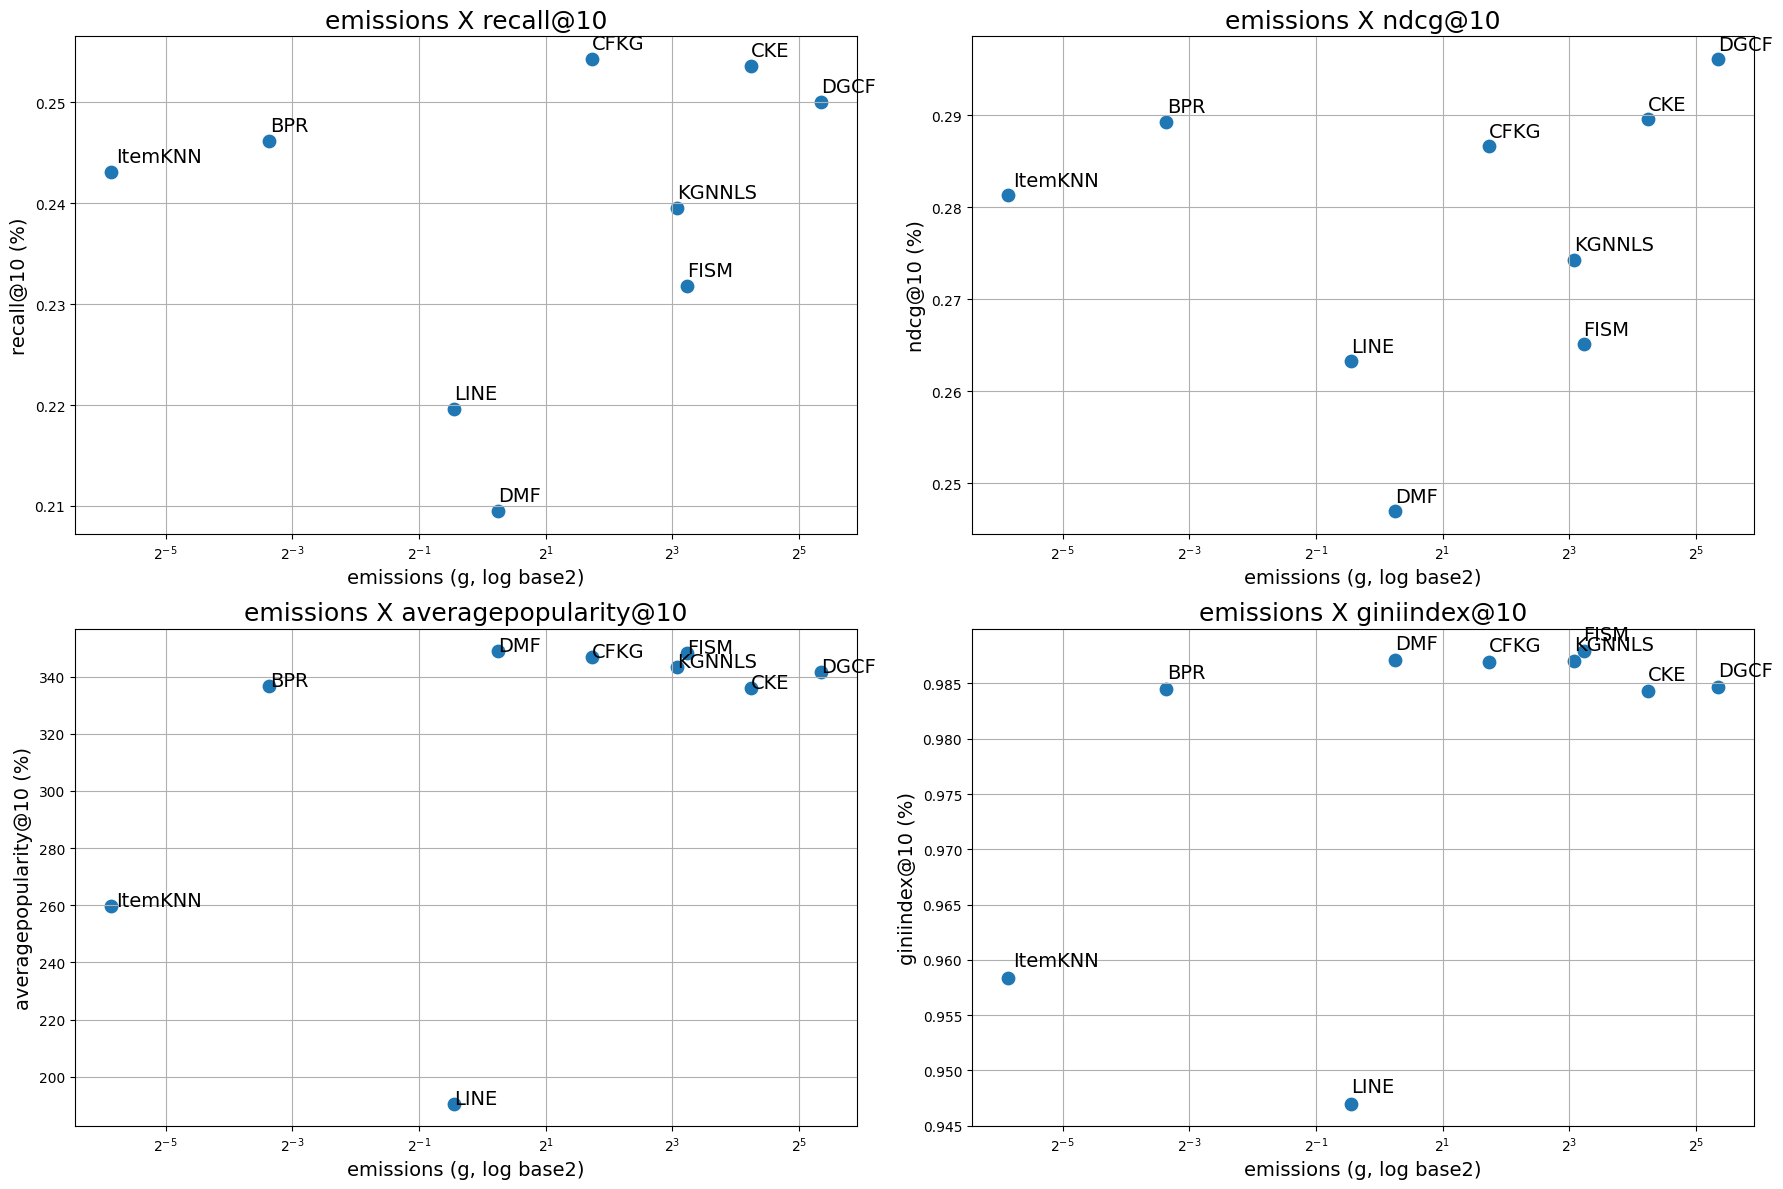

In [17]:
counter = 0
l = [
	['emissions','recall@10'],['emissions','ndcg@10'],['emissions','averagepopularity@10'],['emissions','giniindex@10']
]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
for _, axl in enumerate(axs):
	for _, ax in enumerate(axl):
		ax.scatter(results[l[counter][0]], metrics[l[counter][1]], s=80)
		ax.set_title(l[counter][0]+' X '+l[counter][1], fontsize=18)
		ax.set_xlabel(l[counter][0] + ' (g, log base2)', fontsize=14)
		ax.set_ylabel(l[counter][1] + ' (%)', fontsize=14)
		ax.grid()
		for i, (xi, yi) in enumerate(zip(results[l[counter][0]], metrics[l[counter][1]])):
			ax.text(xi+.001, yi+.001, experiments[i].split('/')[1], fontsize=14)
		ax.set_xscale('log', base=2)
		counter = counter + 1
fig.tight_layout()
plt.show()

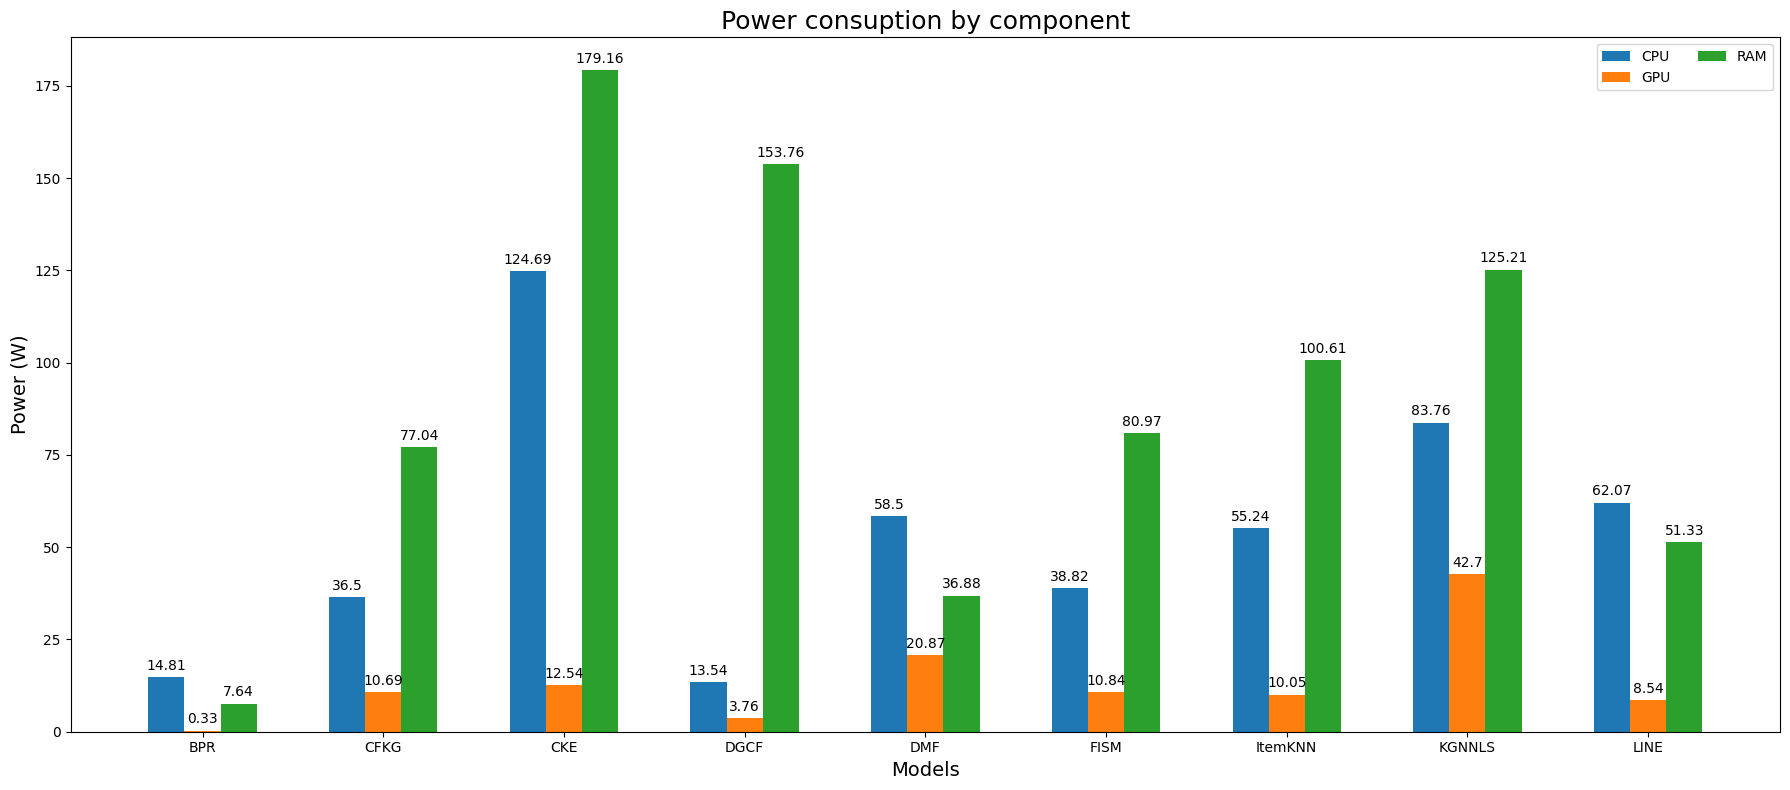

In [21]:
labels_x1 = [l.split('/')[1] for l in experiments]
features_to_plot1 = {'CPU': results['cpu_power'], 'GPU': results['gpu_power'], 'RAM': results['ram_power']}

x1 = np.arange(len(labels_x1))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i, 2) for i in measurement], width, label = attribute)
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_xlabel('Models', fontsize=14)
ax1.set_ylabel('Power (W)', fontsize=14)
ax1.set_title('Power consuption by component', fontsize=18)
ax1.set_xticks(x1 + (width), labels_x1)
ax1.legend(loc = 'upper right', ncol = 2)

fig.tight_layout()
plt.show()